=== DATOS ORIGINALES ===
Rango de fechas: 2022-01-03 00:00:00 a 2024-09-25 00:00:00
Número de registros: 500

=== FEATURES CREADAS ===
De 1 columna (fecha) ahora tenemos 18 columnas:
['fecha', 'año', 'mes', 'dia', 'dia_semana', 'dia_año', 'semana_año', 'trimestre', 'es_fin_semana', 'es_inicio_mes', 'es_fin_mes', 'mes_sin', 'mes_cos', 'dia_semana_sin', 'dia_semana_cos', 'dia_año_sin', 'dia_año_cos', 'dias_desde_inicio']


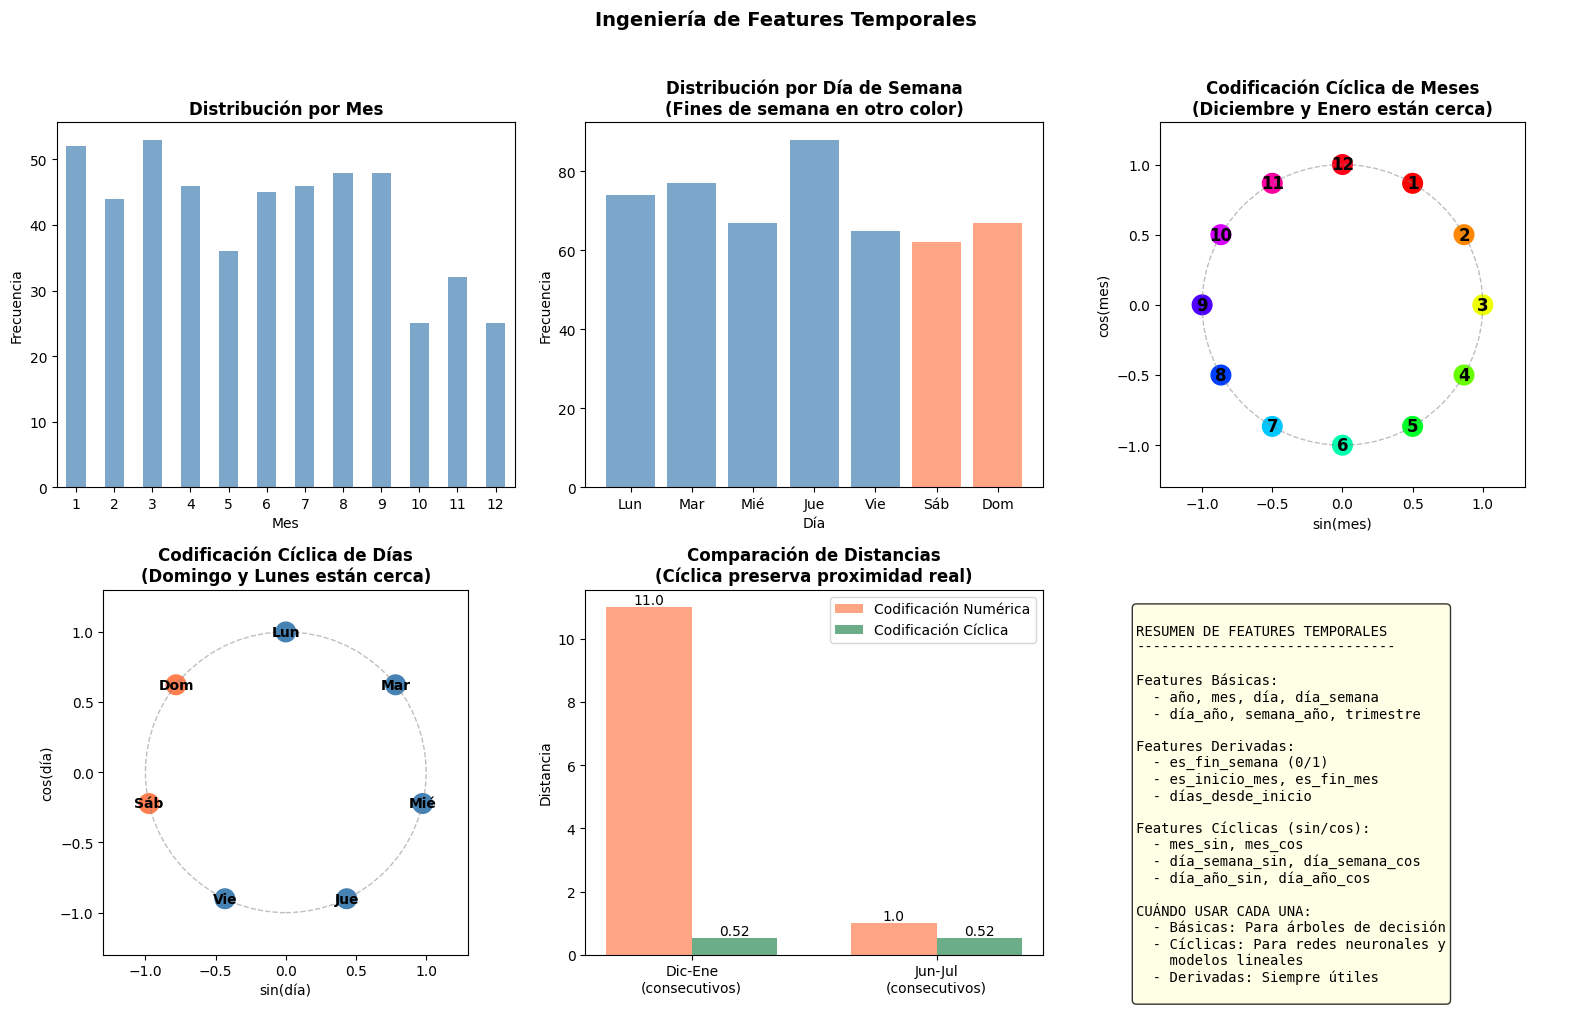


CONCLUSIÓN:
  - De una sola columna de fecha podemos extraer 15+ features
  - La codificación cíclica es crucial para modelos lineales/neuronales
  - Árboles de decisión pueden usar features básicos directamente


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------------------------------------
# PASO 1: CREAR DATOS DE EJEMPLO
# -----------------------------------------------------------

rng = np.random.default_rng(42)

# Generamos fechas en un rango de 2 años
fechas = pd.date_range('2022-01-01', periods=1000, freq='D')
np.random.shuffle(fechas.values)  # Desordenamos

# Creamos DataFrame con 500 fechas únicas
df_fechas = pd.DataFrame({'fecha': fechas[:500]})
df_fechas = df_fechas.sort_values('fecha').reset_index(drop=True)

print("=== DATOS ORIGINALES ===")
print(f"Rango de fechas: {df_fechas['fecha'].min()} a {df_fechas['fecha'].max()}")
print(f"Número de registros: {len(df_fechas)}")

# -----------------------------------------------------------
# PASO 2: FUNCIÓN PARA EXTRAER FEATURES TEMPORALES
# -----------------------------------------------------------

def crear_features_temporales(df, col_fecha):
    """
    Extrae features temporales completas de una columna de fecha.
    
    Parámetros:
    -----------
    df : DataFrame con una columna de fecha
    col_fecha : nombre de la columna que contiene las fechas
    
    Retorna:
    --------
    DataFrame con todas las features temporales añadidas
    """
    df = df.copy()  # No modificamos el original
    fecha = pd.to_datetime(df[col_fecha])  # Aseguramos formato datetime
    
    # =========================================
    # FEATURES BÁSICAS (componentes de fecha)
    # =========================================
    df['año'] = fecha.dt.year
    df['mes'] = fecha.dt.month
    df['dia'] = fecha.dt.day
    df['dia_semana'] = fecha.dt.dayofweek  # 0=Lunes, 6=Domingo
    df['dia_año'] = fecha.dt.dayofyear     # 1-365
    df['semana_año'] = fecha.dt.isocalendar().week.astype(int)  # 1-52
    df['trimestre'] = fecha.dt.quarter     # 1-4
    
    # =========================================
    # FEATURES DERIVADAS (indicadores útiles)
    # =========================================
    df['es_fin_semana'] = (fecha.dt.dayofweek >= 5).astype(int)
    df['es_inicio_mes'] = (fecha.dt.day <= 7).astype(int)
    df['es_fin_mes'] = (fecha.dt.day >= 25).astype(int)
    
    # =========================================
    # FEATURES CÍCLICAS (seno/coseno)
    # Preservan la continuidad del tiempo
    # =========================================
    
    # Mes: ciclo de 12
    df['mes_sin'] = np.sin(2 * np.pi * df['mes'] / 12)
    df['mes_cos'] = np.cos(2 * np.pi * df['mes'] / 12)
    
    # Dia de la semana: ciclo de 7
    df['dia_semana_sin'] = np.sin(2 * np.pi * df['dia_semana'] / 7)
    df['dia_semana_cos'] = np.cos(2 * np.pi * df['dia_semana'] / 7)
    
    # Día del año: ciclo de 365 (captura estacionalidad anual)
    df['dia_año_sin'] = np.sin(2 * np.pi * df['dia_año'] / 365)
    df['dia_año_cos'] = np.cos(2 * np.pi * df['dia_año'] / 365)
    
    # =========================================
    # ANTIGÜEDAD (días desde el inicio)
    # =========================================
    df['dias_desde_inicio'] = (fecha - fecha.min()).dt.days
    
    return df

# Aplicamos la funcion
df_features = crear_features_temporales(df_fechas, 'fecha')

print("\n=== FEATURES CREADAS ===")
print(f"De 1 columna (fecha) ahora tenemos {len(df_features.columns)} columnas:")
print(df_features.columns.tolist())

# -----------------------------------------------------------
# PASO 3: VISUALIZACIÓN
# -----------------------------------------------------------

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Gráfico 1: Distribución por mes
ax1 = axes[0, 0]
df_features['mes'].value_counts().sort_index().plot(kind='bar', ax=ax1, color='steelblue', alpha=0.7)
ax1.set_title('Distribución por Mes', fontweight='bold')
ax1.set_xlabel('Mes')
ax1.set_ylabel('Frecuencia')
ax1.tick_params(axis='x', rotation=0)

# Gráfico 2: Distribución por día de semana
ax2 = axes[0, 1]
dias_nombre = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']
conteo_dias = df_features['dia_semana'].value_counts().sort_index()
# Coloreamos fines de semana diferente
colors_dias = ['steelblue']*5 + ['coral']*2
ax2.bar(dias_nombre, conteo_dias.values, color=colors_dias, alpha=0.7)
ax2.set_title('Distribución por Día de Semana\n(Fines de semana en otro color)', fontweight='bold')
ax2.set_xlabel('Día')
ax2.set_ylabel('Frecuencia')

# Gráfico 3: Codificación cíclica del mes (en círculo)
ax3 = axes[0, 2]
# Obtenemos las coordenadas sin/cos de cada mes
meses_unicos = df_features.groupby('mes')[['mes_sin', 'mes_cos']].first()
ax3.scatter(meses_unicos['mes_sin'], meses_unicos['mes_cos'], s=200, 
            c=meses_unicos.index, cmap='hsv')
# Etiquetamos cada punto con el número de mes
for mes in meses_unicos.index:
    ax3.annotate(str(mes), 
                 (meses_unicos.loc[mes, 'mes_sin'], meses_unicos.loc[mes, 'mes_cos']),
                 fontsize=12, ha='center', va='center', fontweight='bold')
ax3.set_xlabel('sin(mes)')
ax3.set_ylabel('cos(mes)')
ax3.set_title('Codificación Cíclica de Meses\n(Diciembre y Enero están cerca)', fontweight='bold')
ax3.set_xlim(-1.3, 1.3)
ax3.set_ylim(-1.3, 1.3)
ax3.set_aspect('equal')
# Dibujamos un círculo de referencia
circle = plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='--', alpha=0.5)
ax3.add_patch(circle)

# Gráfico 4: Codificación cíclica de días de semana
ax4 = axes[1, 0]
dias_unicos = df_features.groupby('dia_semana')[['dia_semana_sin', 'dia_semana_cos']].first()
ax4.scatter(dias_unicos['dia_semana_sin'], dias_unicos['dia_semana_cos'], s=200, 
            c=['steelblue']*5 + ['coral']*2)
for dia, nombre in zip(dias_unicos.index, dias_nombre):
    ax4.annotate(nombre, 
                 (dias_unicos.loc[dia, 'dia_semana_sin'], dias_unicos.loc[dia, 'dia_semana_cos']),
                 fontsize=10, ha='center', va='center', fontweight='bold')
ax4.set_xlabel('sin(día)')
ax4.set_ylabel('cos(día)')
ax4.set_title('Codificación Cíclica de Días\n(Domingo y Lunes están cerca)', fontweight='bold')
ax4.set_xlim(-1.3, 1.3)
ax4.set_ylim(-1.3, 1.3)
ax4.set_aspect('equal')
circle = plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='--', alpha=0.5)
ax4.add_patch(circle)

# Gráfico 5: Demostración de por qué importa la codificación cíclica
ax5 = axes[1, 1]

# Calculamos distancias entre meses consecutivos
# Diciembre-Enero: numéricamente están lejos (12-1=11), pero son consecutivos
dist_numerica_dic_ene = abs(12 - 1)  # = 11
dist_ciclica_dic_ene = np.sqrt(
    (np.sin(2*np.pi*12/12) - np.sin(2*np.pi*1/12))**2 + 
    (np.cos(2*np.pi*12/12) - np.cos(2*np.pi*1/12))**2
)

# Junio-Julio: numéricamente cerca (7-6=1), y también son consecutivos
dist_numerica_jun_jul = abs(6 - 7)  # = 1
dist_ciclica_jun_jul = np.sqrt(
    (np.sin(2*np.pi*6/12) - np.sin(2*np.pi*7/12))**2 + 
    (np.cos(2*np.pi*6/12) - np.cos(2*np.pi*7/12))**2
)

x_labels = ['Dic-Ene\n(consecutivos)', 'Jun-Jul\n(consecutivos)']
bar_width = 0.35
x = np.arange(len(x_labels))

bars1 = ax5.bar(x - bar_width/2, [dist_numerica_dic_ene, dist_numerica_jun_jul], bar_width, 
                label='Codificación Numérica', color='coral', alpha=0.7)
bars2 = ax5.bar(x + bar_width/2, [dist_ciclica_dic_ene, dist_ciclica_jun_jul], bar_width,
                label='Codificación Cíclica', color='seagreen', alpha=0.7)

ax5.set_ylabel('Distancia')
ax5.set_title('Comparación de Distancias\n(Cíclica preserva proximidad real)', fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels(x_labels)
ax5.legend()

# Anotamos los valores en las barras
for bar in bars1:
    ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{bar.get_height():.1f}', ha='center', fontsize=10)
for bar in bars2:
    ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{bar.get_height():.2f}', ha='center', fontsize=10)

# Gráfico 6: Resumen de features
ax6 = axes[1, 2]
ax6.axis('off')

features_info = """
RESUMEN DE FEATURES TEMPORALES
-------------------------------

Features Básicas:
  - año, mes, día, día_semana
  - día_año, semana_año, trimestre

Features Derivadas:
  - es_fin_semana (0/1)
  - es_inicio_mes, es_fin_mes
  - días_desde_inicio

Features Cíclicas (sin/cos):
  - mes_sin, mes_cos
  - día_semana_sin, día_semana_cos
  - día_año_sin, día_año_cos

CUÁNDO USAR CADA UNA:
  - Básicas: Para árboles de decisión
  - Cíclicas: Para redes neuronales y
    modelos lineales
  - Derivadas: Siempre útiles
"""

ax6.text(0.05, 0.95, features_info, transform=ax6.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.suptitle('Ingeniería de Features Temporales', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('grafico_features_temporales.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nCONCLUSIÓN:")
print("  - De una sola columna de fecha podemos extraer 15+ features")
print("  - La codificación cíclica es crucial para modelos lineales/neuronales")
print("  - Árboles de decisión pueden usar features básicos directamente")